In [105]:
import networkx as nx
import json
import numpy as np

In [116]:
filename = "data/TokyoArea202063-tokyo.json"
with open(filename, encoding='utf-8') as f:
    js_graph = json.load(f)

In [29]:
def openJSONMultiDiGraph(filename):
    with open(filename, encoding='utf-8-sig') as f:
        js_graph = json.load(f)
    return nx.json_graph.node_link_graph(js_graph, directed=True, multigraph=True)

In [30]:
def makeDirectedRoadNetwork():
    driveSpeedByRoadType = {'motorway':60, 'motorway_link':40, 'trunk':30, 'trunk_link':30, 'primary':30, 'primary_link':30, 'secondary':30, 'secondary_link':30, 'tertiary':30, 'tertiary_link':30, 'road':25}
#    roadWidthByRoadType = { 'motorway':21, 'motorway_link':10.5, 'trunk':14, 'trunk_link':7, 'primary':9, 'primary_link':4.5, 'secondary':6, 'secondary_link':3, 'tertiary':5.5,  'tertiary_link':2.75, 'road':6}
    lanesByRoadType = {'motorway':3, 'motorway_link':1, 'trunk':2, 'trunk_link':1, 'primary':2, 'primary_link':1, 'secondary':1, 'secondary_link':1, 'tertiary':1, 'tertiary_link':1, 'road':1}
#    hourlyCapacityByRoadType = { 'motorway':6000, 'motorway_link':2000, 'trunk':4000, 'trunk_link':2000, 'primary':2000, 'primary_link':1000, 'secondary':1000, 'secondary_link':1000, 'tertiary':1000,  'tertiary_link':1000, 'road':500}
    capacityByRoadType = { 'motorway':24000, 'motorway_link':8000, 'trunk':16000, 'trunk_link':8000, 'primary':8000, 'primary_link':4000, 'secondary':4000, 'secondary_link':4000, 'tertiary':4000,  'tertiary_link':4000, 'road':2000}
    
#    print(linkData.head(15))
    linkData['driveSpeed'] = linkData.apply(lambda row: driveSpeedByRoadType[row.roadType], axis=1)
    linkData['capacity'] = linkData.apply(lambda row: capacityByRoadType[row.roadType], axis=1)
    linkData['numLanes'] = linkData.apply(lambda row: lanesByRoadType[row.roadType], axis=1)
    linkData = linkData.drop(['id'], axis=1)
    
    ###----ADD THE ROAD TYPE TO THE ROAD NETWORK
    linkData['modality'] = 'road'
    nodeData['modality'] = 'road'
        
    ##----Build the network from the road links and remove nodes that are not intersections or endpoints
    ##----NOTE THAT IT IS A DIRECTED GRAPH NOW
    roadNetwork2 = nx.from_pandas_edgelist(linkData, 'source', 'target', True, nx.DiGraph())
    roadNetwork = roadNetwork2.copy()
    print("Number of nodes in unfiltered link network:",len(roadNetwork.nodes))
    numNodes = len(roadNetwork.nodes)
    
#    print(list(roadNetwork.edges(data=True))[0])
    
    ##-- Reduce the network by removing nodes that are not intersections
    ##-- The OSM data includes lists of nodes for each road segment, some are just for shape, and some are intersections
    ##-- Ones that are just for shape have degree == 2
#    nodesWithDegreeTwo = [node for node,degree in roadNetwork.degree() if degree == 2]
#    print("Number of nodes with degree = 2:",len(nodesWithDegreeTwo))    
    nodesWithInDegreeOne = [node for node,inDegree in roadNetwork.in_degree() if inDegree == 1]    
    nodesWithOutDegreeOne = [node for node,outDegree in roadNetwork.out_degree() if outDegree == 1]
    nodesWithInOutDegreeOne = list(set(nodesWithInDegreeOne) & set(nodesWithOutDegreeOne))
    print("Number of nodes with in- and out-degree = 1:",len(nodesWithInOutDegreeOne))
    
    ##-- Delete nodes with degree == 2 (edges of same type) and connect its two neighbors with a new link that inherits from the "left".
    for node in nodesWithInOutDegreeOne:
        edge1 = list(roadNetwork.in_edges(node,data=True))[0]         
        edge2 = list(roadNetwork.out_edges(node,data=True))[0]  
        ##-- only fuse the links if they are the same road type
        if edge1[2]['roadType'] == edge2[2]['roadType']:
            roadNetwork.add_edge(edge1[0], edge2[1], roadType = edge1[2]['roadType'], roadName = edge1[2]['roadName'], oneWay = edge1[2]['oneWay'], speedLimit = edge1[2]['speedLimit'], roadWidth = edge1[2]['roadWidth'], driveSpeed = edge1[2]['driveSpeed'], capacity = edge1[2]['capacity'], numLanes = edge1[2]['numLanes'], modality = edge1[2]['modality'])
            roadNetwork.remove_node(node)
    
    print("Number of nodes filtered from road network:", numNodes - len(roadNetwork.nodes))
    print("Number of nodes in filtered road network:",len(roadNetwork.nodes))
    
    ###--- ARE THERE STILL NODES WITH DEGREE == 2?  This is now reasonable if the edges are different road types
    nodesWithInDegreeOne = [node for node,inDegree in roadNetwork.in_degree() if inDegree == 1]    
    nodesWithOutDegreeOne = [node for node,outDegree in roadNetwork.out_degree() if outDegree == 1]
    nodesWithInOutDegreeOne = list(set(nodesWithInDegreeOne) & set(nodesWithOutDegreeOne))
    print("Number of filtered nodes with in- and out-degree = 1:",len(nodesWithInOutDegreeOne))
    
    ##-- Check that I didn't delete too much: this should still be zero
    nodesWithDegreeZero = [node for node,degree in roadNetwork.degree() if degree == 0]
    print("Number of filtered nodes with degree = 0:",len(nodesWithDegreeZero))
        
    ###--- Remove nodes that are not connected to any roads ... there aren't any because all nodes are created via the linklist 
    #for node in list(roadNetwork.nodes()):
    #    if roadNetwork.degree(node) == 0:
    #        roadNetwork.remove_node(node)
        
    ####----Add the GIS coords from the nodeData to the nodes
    nx.set_node_attributes(roadNetwork, nodeData.set_index('id').to_dict('index'))
    
    ####----Go through each link and use the GIS coords of the nodes to determine the approx linkLength, then using speed limits, and add time value.
    for edge in list(roadNetwork.edges(data=True)):
        x1 = roadNetwork.nodes(data=True)[edge[0]]['lon']
        y1 = roadNetwork.nodes(data=True)[edge[0]]['lat']
        x2 = roadNetwork.nodes(data=True)[edge[1]]['lon']
        y2 = roadNetwork.nodes(data=True)[edge[1]]['lat']
        distanceBetweenNodes = distanceBetweenLonLats(x1,y1,x2,y2)
    #    print("dist:",distanceBetweenNodes)
    #    print("speedlimit:",roadNetwork.edges[edge[0],edge[1]]['speedLimit'])
        ##-- Caluculate time based on driveSpeed rather than speedLimit, although still no penalty for turns/traffic/etc.
        timeWeight = ((distanceBetweenNodes / 1000) / roadNetwork.edges[edge[0],edge[1]]['driveSpeed']) * 60  ## the time in minutes
        roadNetwork.edges[edge[0],edge[1]]['x1'] = x1
        roadNetwork.edges[edge[0],edge[1]]['y1'] = y1
        roadNetwork.edges[edge[0],edge[1]]['x2'] = x2
        roadNetwork.edges[edge[0],edge[1]]['y2'] = y2
        roadNetwork.edges[edge[0],edge[1]]['distance'] = makeInt(distanceBetweenNodes)   
        roadNetwork.edges[edge[0],edge[1]]['timeWeight'] = np.round(timeWeight, decimals=1)  
        
        ####---- Create reciprical links for non-oneway roads
        if edge[2]['oneWay'] == 0:
            roadNetwork.add_edge(edge[1], edge[0], roadType = edge[2]['roadType'], roadName = edge[2]['roadName'], oneWay = edge[2]['oneWay'], speedLimit = edge[2]['speedLimit'], roadWidth = edge[2]['roadWidth'], driveSpeed = edge[2]['driveSpeed'], x1 = edge[2]['x1'], y1 = edge[2]['y1'], x2 = edge[2]['x2'], y2 = edge[2]['y2'], distance = edge[2]['distance'], timeWeight = edge[2]['timeWeight'], modality = edge[2]['modality'], capacity = edge[2]['capacity'], numLanes = edge[2]['numLanes'])
    
    #    print(list(roadNetwork.nodes(data=True))[10])
    #    print(list(roadNetwork.edges(data=True))[10])

    print("Number of roadNetwork nodes:",len(roadNetwork.nodes))
    print("Number of roadNetwork links:",len(roadNetwork.edges))
    
    ####### ==================== EXPORT JSON OF NETWORKX ROAD GRAPH ===================    
    print("==== Writing Road Network File ====")
    writeJSONFile(roadNetwork,'G:/My Drive/Data/RoadNetworks/roadNetwork3-Directed-TokyoArea.json')
    

In [31]:
graph = openJSONMultiDiGraph(filename)

KeyError: 'nodes'

In [37]:
import os
data_path = os.path.join(os.environ["DATA_PATH"], "RoadNetworks")
DATA_PATH = "data/"

In [38]:
import pandas as pd

In [94]:
linkData = pd.read_csv(os.path.join(DATA_PATH, "linkData-TokyoArea-v2.csv"), encoding='utf-8')
nodeData = pd.read_csv(os.path.join(DATA_PATH, "nodeData-TokyoArea-v2.csv"), encoding='utf-8')

/Users/s_araki/.pyenv/versions/3.6.5/envs/geoanalysis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/s_araki/.pyenv/versions/3.6.5/envs/geoanalysis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [95]:
linkData.columns = linkData.iloc[0, :]
linkData = linkData.iloc[1:, :]

In [96]:
linkData

,@id,@type,highway,name,oneway,maxspeed,width,@nodes
1,4847506,way,motorway,首都高速11号台場線,yes,NaN,NaN,NaN
2,4847507,way,motorway,首都高速湾岸線,yes,60,NaN,NaN
3,4847509,way,motorway_link,NaN,yes,NaN,NaN,NaN
4,4847513,way,tertiary,NaN,yes,NaN,NaN,NaN
5,4847514,way,tertiary,NaN,yes,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1775831,7589692736,node,NaN,NaN,NaN,NaN,NaN,NaN
1775832,7589692737,node,NaN,NaN,NaN,NaN,NaN,NaN
1775833,7589692738,node,NaN,NaN,NaN,NaN,NaN,NaN
1775834,7590006648,node,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
nodeData.columns = nodeData.iloc[0, :]
nodeData = nodeData.iloc[1:, :]

In [98]:
nodeData

,@id,@lat,@lon
1,4847506,NaN,NaN
2,4847507,NaN,NaN
3,4847509,NaN,NaN
4,4847513,NaN,NaN
5,4847514,NaN,NaN
...,...,...,...
1775831,7589692736,35.6058,139.42
1775832,7589692737,35.6055,139.421
1775833,7589692738,35.6055,139.421
1775834,7590006648,35.7765,139.302


In [99]:
linkData.isnull().sum() / linkData.shape[0]

0
@id         0.000000
@type       0.000000
highway     0.872819
name        0.985479
oneway      0.985789
maxspeed    0.993546
width       0.999733
@nodes      1.000000
dtype: float64

In [100]:
nodeData.isnull().sum() / linkData.shape[0]

0
@id     0.000000
@lat    0.103846
@lon    0.103846
dtype: float64

In [132]:
filename = "data/allData-TokyoArea-v2.json"
with open(filename, encoding='utf-8') as f:
    js_graph = json.load(f)

In [133]:
edges = np.array(js_graph['elements'], copy=True)
len(edges)

1775835

In [134]:
edges

array([{'type': 'way', 'id': 4847506, 'nodes': [31236733, 621545916, 621545917, 31236732, 1832774251, 1832774248, 31236568, 31236567, 31236566, 1832774235, 621545902, 31236565, 621545903, 1832774226, 31236564, 621545901, 1832774190, 621545904, 31236563, 1832774171, 1832774167, 621545900], 'tags': {'bridge': 'yes', 'highway': 'motorway', 'lanes': '2', 'layer': '4', 'name': '首都高速11号台場線', 'name:en': 'Daiba Route', 'name:es': 'Ruta Daiba', 'name:ja': '首都高速11号台場線', 'name:ru': 'Шоссе Дайба', 'oneway': 'yes', 'ref': '11'}},
       {'type': 'way', 'id': 4847507, 'nodes': [31300417, 31300416, 31300384, 3799099877, 498126182, 31288751, 570755428], 'tags': {'bicycle': 'no', 'foot': 'no', 'highway': 'motorway', 'maxspeed': '60', 'motorcar': 'designated', 'motorcycle': 'designated', 'name': '首都高速湾岸線', 'name:en': 'Bayshore Route', 'name:es': 'Ruta Bayshore', 'name:ja': '首都高速湾岸線', 'name:ko': '수도고속도로 완간선', 'name:ru': 'Прибрежная дорога', 'oneway': 'yes', 'ref': 'B', 'smoothness': 'excellent', 'source'

In [135]:
link_df = pd.DataFrame()
for edge in edges_copy[:5]:
    tags = edge['tags']
    del edge['tags']
    part = pd.DataFrame(edge)
    link_df = pd.concat([link_df, part])

KeyError: 'tags'

In [142]:
link_df.groupby('id').agg('count')

KeyError: 'id'

In [145]:
from collections import defaultdict
original_tags = edges_copy[6]['tags']
tags = defaultdict(None, **original_tags)
tags

defaultdict(None,
            {'bridge': 'yes',
             'highway': 'motorway',
             'layer': '2',
             'name': '首都高速11号台場線',
             'name:en': 'Daiba Route',
             'name:es': 'Ruta Daiba',
             'name:ja': '首都高速11号台場線',
             'name:ru': 'Шоссе Дайба',
             'oneway': 'yes',
             'ref': '11'})

In [148]:
attrs = pd.DataFrame({
                        'roadType': tags['highway'],
                        'roadName': tags['name'],
                        'oneWay': tags['oneway'],
                        'speedLimit': tags['maxspeed'],
                        'roadWidth': tags['width']
                     })
attrs

KeyError: 'maxspeed'

In [139]:
part0 = pd.DataFrame(edges_copy[0])
part1 = pd.DataFrame(edges_copy[1])
part = pd.concat([part0, part1])
part.groupby('id').agg('count')

,type,nodes
id,,
4847506,22,22
4847507,7,7


In [169]:
nodeData = pd.read_csv("data/nodeData-TokyoArea-v2.csv")
linkData = pd.read_csv("data/linkData-TokyoArea-v2.csv")

/Users/s_araki/.pyenv/versions/3.6.5/envs/geoanalysis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [170]:
nodeData

,id,lat,lon
0,1400448932,24.750486,141.288903
1,1400448933,24.750603,141.288842
2,1400448934,24.750684,141.288772
3,1400448936,24.750784,141.288663
4,1400448945,24.750947,141.288507
...,...,...,...
7411499,7591153677,35.440402,139.397418
7411500,7591165588,35.440159,139.396845
7411501,7591165589,35.440377,139.396980
7411502,7591165682,35.440415,139.395728


In [171]:
linkData2 = linkData.loc[~((linkData.roadType == 'unclassified') | (linkData.roadType == 'residential') | (linkData.roadType == 'living_street') | (linkData.roadType == 'pedestrian'))]
linkData2

,type,id,nodes,roadType,roadName,oneWay,speedLimit,roadWidth
0,way,4847506,"[31236733, 621545916, 621545917, 31236732, 183...",motorway,首都高速11号台場線,yes,NaN,NaN
1,way,4847507,"[31300417, 31300416, 31300384, 3799099877, 498...",motorway,首都高速湾岸線,yes,60,NaN
2,way,4847509,"[31236654, 2805815266, 31236651, 2805815274, 3...",motorway_link,NaN,yes,NaN,NaN
3,way,4847513,"[1832774262, 1832774263]",tertiary,NaN,yes,NaN,NaN
4,way,4847514,"[31252838, 573283112, 31252812, 1876066967, 31...",tertiary,NaN,yes,NaN,NaN
...,...,...,...,...,...,...,...,...
781014,way,810760440,"[2007388380, 1801724384, 7570079891, 366699205]",primary,中原街道,yes,60,NaN
781026,way,812570405,"[2007388300, 5963986176, 2007388307]",tertiary,NaN,NaN,30,NaN
781027,way,812570406,"[2007388307, 301043947, 1807075826, 301043960,...",tertiary,NaN,NaN,30,NaN
781030,way,812570409,"[7589639359, 1565442298, 1837262575, 156544232...",primary,厚木街道,NaN,40,NaN


In [173]:
speedLimitByRoadType = {'motorway':80, 'motorway_link':60, 'trunk':60, 'trunk_link':50, 'primary':50, 'primary_link':50, 'secondary':40, 'secondary_link':40, 'tertiary':30, 'tertiary_link':30, 'road':30}
driveSpeedByRoadType = {'motorway':60, 'motorway_link':40, 'trunk':30, 'trunk_link':30, 'primary':30, 'primary_link':30, 'secondary':30, 'secondary_link':30, 'tertiary':30, 'tertiary_link':30, 'road':25}
roadWidthByRoadType = {'motorway':21, 'motorway_link':10.5, 'trunk':14, 'trunk_link':7, 'primary':9, 'primary_link':4.5, 'secondary':6, 'secondary_link':3, 'tertiary':5.5,  'tertiary_link':2.75, 'road':6}

## Explore missing values: `oneWay`

In [174]:
linkData2.isnull().sum() / linkData2.shape[0]

type          0.000000
id            0.000000
nodes         0.000000
roadType      0.000000
roadName      0.566850
oneWay        0.653292
speedLimit    0.762469
roadWidth     0.998992
dtype: float64

In [178]:
linkData2[~(linkData2.oneWay.isnull())]

,type,id,nodes,roadType,roadName,oneWay,speedLimit,roadWidth
0,way,4847506,"[31236733, 621545916, 621545917, 31236732, 183...",motorway,首都高速11号台場線,yes,NaN,NaN
1,way,4847507,"[31300417, 31300416, 31300384, 3799099877, 498...",motorway,首都高速湾岸線,yes,60,NaN
2,way,4847509,"[31236654, 2805815266, 31236651, 2805815274, 3...",motorway_link,NaN,yes,NaN,NaN
3,way,4847513,"[1832774262, 1832774263]",tertiary,NaN,yes,NaN,NaN
4,way,4847514,"[31252838, 573283112, 31252812, 1876066967, 31...",tertiary,NaN,yes,NaN,NaN
...,...,...,...,...,...,...,...,...
781010,way,810760436,"[2007388379, 2007388376]",primary,中原街道,yes,50,NaN
781011,way,810760437,"[1806105883, 2007388369]",primary,中原街道,yes,50,NaN
781012,way,810760438,"[2007388369, 7570072657, 1563061235]",primary,中原街道,yes,50,NaN
781013,way,810760439,"[1808829863, 2007388380]",primary,中原街道,yes,60,NaN


In [181]:
linkData2.groupby('oneWay').agg('count').id

oneWay
-1              181
1                 1
no             2394
reversible        1
yes           29065
Name: id, dtype: int64

### Conclusion 1: It's probably okay to set the `oneWay` default to `0` and `1` if it's 'yes'

## Explore missing values: `speedLimit`

In [182]:
linkData2.groupby('speedLimit').agg('count').id

speedLimit
20.0         3
30.0       220
40.0      1111
50.0       458
60.0       546
70.0        58
80.0       338
100.0      549
100        585
100.0       43
20          60
30        4649
30.0        30
30;40       10
40        7708
40.0       241
40; 30       4
40;30        1
50        3291
50.0        87
50;40        4
60         881
60.0       105
70         229
70.0         1
80         444
80.0        22
Name: id, dtype: int64

## Why duplicates in the `nodeData`?? Idk.

In [187]:
nodeData.groupby('id').agg('count')

,lat,lon
id,,
31236558,2,2
31236561,2,2
31236562,2,2
31236563,2,2
31236564,2,2
...,...,...
7591153677,2,2
7591165588,2,2
7591165589,2,2


In [188]:
nodeData.drop_duplicates(subset='id', inplace=True)

In [189]:
nodeData.groupby('id').agg('count')

,lat,lon
id,,
31236558,1,1
31236561,1,1
31236562,1,1
31236563,1,1
31236564,1,1
...,...,...
7591153677,1,1
7591165588,1,1
7591165589,1,1


In [190]:
nodeData.to_csv('data/nodeData-clean-TokyoArea-v2.csv', sep=',', encoding='utf-8-sig', index=False)

In [193]:
def openJSONDiGraph(filename):
    with open(filename, encoding='utf-8-sig') as f:
        js_graph = json.load(f)
    return nx.json_graph.node_link_graph(js_graph, directed=True, multigraph=False)

In [194]:
filename = "data/roadNetwork-Directed-TokyoArea-v2.json"

In [195]:
G = openJSONDiGraph(filename)
G

In [198]:
len(G.edges), len(G.nodes)

(1595793, 876869)

In [204]:
time_weights = [data['timeWeight'] for _, _, data in G.edges(data=True)]
time_weights

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [205]:
import seaborn as sns

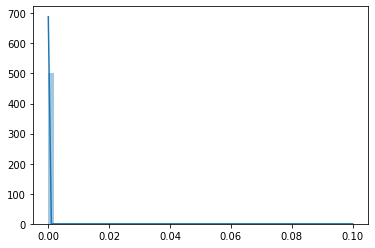

In [206]:
sns.distplot(time_weights)

In [207]:
time_weights = np.array(time_weights)
time_weights.mean()

1.2532953835491196e-07

In [209]:
# slopeSimple (for every edge, calculate simple slope)

0.00011195060575092071

In [227]:
linkData = pd.read_csv('data/elevationLinkData-TokyoArea-v2.csv')

In [228]:
linkData

,Unnamed: 0,id,roadType,roadName,oneWay,speedLimit,roadWidth,driveSpeed,source,target,elevationGain
0,0,4847506,motorway,首都高速11号台場線,1,80,21.0,60,31236733,621545916,[nan]
1,1,4847506,motorway,首都高速11号台場線,1,80,21.0,60,621545916,621545917,[nan]
2,2,4847506,motorway,首都高速11号台場線,1,80,21.0,60,621545917,31236732,[nan]
3,3,4847506,motorway,首都高速11号台場線,1,80,21.0,60,31236732,1832774251,[nan]
4,4,4847506,motorway,首都高速11号台場線,1,80,21.0,60,1832774251,1832774248,[nan]
...,...,...,...,...,...,...,...,...,...,...,...
910716,910716,812570409,primary,厚木街道,0,30,9.0,5,1565442394,7570072604,[nan]
910717,910717,812570409,primary,厚木街道,0,30,9.0,5,7570072604,1565442396,[nan]
910718,910718,812570409,primary,厚木街道,0,30,9.0,5,1565442396,7570072605,[nan]
910719,910719,812570409,primary,厚木街道,0,30,9.0,5,7570072605,7309294738,[nan]


In [234]:
linkData.loc[ linkData.elevationGain == "[nan]" ]

,Unnamed: 0,id,roadType,roadName,oneWay,speedLimit,roadWidth,driveSpeed,source,target,elevationGain
0,0,4847506,motorway,首都高速11号台場線,1,80,21.0,60,31236733,621545916,[nan]
1,1,4847506,motorway,首都高速11号台場線,1,80,21.0,60,621545916,621545917,[nan]
2,2,4847506,motorway,首都高速11号台場線,1,80,21.0,60,621545917,31236732,[nan]
3,3,4847506,motorway,首都高速11号台場線,1,80,21.0,60,31236732,1832774251,[nan]
4,4,4847506,motorway,首都高速11号台場線,1,80,21.0,60,1832774251,1832774248,[nan]
...,...,...,...,...,...,...,...,...,...,...,...
910716,910716,812570409,primary,厚木街道,0,30,9.0,5,1565442394,7570072604,[nan]
910717,910717,812570409,primary,厚木街道,0,30,9.0,5,7570072604,1565442396,[nan]
910718,910718,812570409,primary,厚木街道,0,30,9.0,5,1565442396,7570072605,[nan]
910719,910719,812570409,primary,厚木街道,0,30,9.0,5,7570072605,7309294738,[nan]


In [257]:
nodeData = pd.read_csv('data/elevationNodeData-TokyoArea-v3.csv')
nodeData

,Unnamed: 0,id,lat,lon,elevation
0,624576,410504245,35.711787,139.741724,18.730000
1,624577,410504246,35.711630,139.741636,18.280001
2,624578,410504247,35.711073,139.741304,12.440000
3,624579,410504248,35.710576,139.741075,6.700000
4,624580,410504563,35.710546,139.741349,6.590000
5,624625,1104760153,35.710482,139.741936,6.450000
6,624759,2295454054,35.711979,139.741864,20.100000
7,624809,2954694922,35.710588,139.741017,6.690000
8,624864,6089493112,35.710511,139.741728,6.550000
9,624868,6089493150,35.710539,139.741413,6.600000


In [284]:
savedNodes = pd.read_csv("savepoint_elevationData.csv")
savedNodes

,id,lat,lon,thisPoint,elevation
0,1400448932,24.750486,141.288903,POINT (141.288903 24.750486),NaN
1,1400448933,24.750603,141.288842,POINT (141.288842 24.750603),NaN
2,1400448934,24.750684,141.288772,POINT (141.288772 24.750684),NaN
3,1400448936,24.750784,141.288663,POINT (141.288663 24.750784),NaN
4,1400448945,24.750947,141.288507,POINT (141.288507 24.750947),NaN
...,...,...,...,...,...
3694804,6502211476,35.571015,139.671924,POINT (139.6719244 35.5710154),NaN
3694805,6502211477,35.571014,139.671329,POINT (139.6713289 35.57101420000001),NaN
3694806,6502211688,35.570163,139.672337,POINT (139.6723373 35.57016289999999),NaN
3694807,6502211693,35.569847,139.671568,POINT (139.6715677 35.5698474),NaN


In [285]:
savedNodes

,id,lat,lon,thisPoint,elevation
0,1400448932,24.750486,141.288903,POINT (141.288903 24.750486),NaN
1,1400448933,24.750603,141.288842,POINT (141.288842 24.750603),NaN
2,1400448934,24.750684,141.288772,POINT (141.288772 24.750684),NaN
3,1400448936,24.750784,141.288663,POINT (141.288663 24.750784),NaN
4,1400448945,24.750947,141.288507,POINT (141.288507 24.750947),NaN
...,...,...,...,...,...
3694804,6502211476,35.571015,139.671924,POINT (139.6719244 35.5710154),NaN
3694805,6502211477,35.571014,139.671329,POINT (139.6713289 35.57101420000001),NaN
3694806,6502211688,35.570163,139.672337,POINT (139.6723373 35.57016289999999),NaN
3694807,6502211693,35.569847,139.671568,POINT (139.6715677 35.5698474),NaN


In [320]:
from shapely.geometry import Point
from helpers.helperFunctions import fullFileName, readPickleFile
from shapely.strtree import STRtree

In [289]:
theData = pd.read_csv("data/nodeData-clean-TokyoArea-v2.csv")
theData.loc[:,'thisPoint'] = theData.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
theData['elevation'] = [None] * len(theData)

In [283]:
# 6428.89 secs for 41200 rows --> 0.156 secs per row

In [290]:
theData

,id,lat,lon,thisPoint,elevation
0,1400448932,24.750486,141.288903,POINT (141.288903 24.750486),None
1,1400448933,24.750603,141.288842,POINT (141.288842 24.750603),None
2,1400448934,24.750684,141.288772,POINT (141.288772 24.750684),None
3,1400448936,24.750784,141.288663,POINT (141.288663 24.750784),None
4,1400448945,24.750947,141.288507,POINT (141.288507 24.750947),None
...,...,...,...,...,...
3694804,6502211476,35.571015,139.671924,POINT (139.6719244 35.5710154),None
3694805,6502211477,35.571014,139.671329,POINT (139.6713289 35.57101420000001),None
3694806,6502211688,35.570163,139.672337,POINT (139.6723373 35.57016289999999),None
3694807,6502211693,35.569847,139.671568,POINT (139.6715677 35.5698474),None


In [294]:
boundaryDict = readPickleFile(fullFileName('Altitude/Elevation5mWindowFiles/boundaryDict.pkl'))

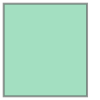

In [315]:
geo = list(boundaryDict.items())[100][1]['geometry']
geo

In [317]:
relevantData = theData.loc[theData['thisPoint'].map(lambda p: p.intersects(geo))]
relevantData
# theData['thisPoint']

,id,lat,lon,thisPoint,elevation
1907649,299718646,35.863803,139.185046,POINT (139.185046 35.8638029),None
1907650,299718647,35.863864,139.184913,POINT (139.1849132 35.8638641),None
1907651,299718670,35.863891,139.184564,POINT (139.1845641 35.86389060000001),None
1907652,299718676,35.863473,139.183833,POINT (139.1838334 35.8634727),None
1907653,299718679,35.863376,139.183429,POINT (139.1834289 35.86337550000001),None
...,...,...,...,...,...
1948296,5492505958,35.886420,139.199757,POINT (139.1997566 35.8864201),None
1948297,5492505959,35.886322,139.199275,POINT (139.1992755 35.8863219),None
1948298,5492505960,35.886244,139.199026,POINT (139.199026 35.8862437),None
1948299,5492505961,35.886171,139.198837,POINT (139.1988371 35.8861711),None


In [319]:
k = 100
thisBlock = readPickleFile(fullFileName('Altitude/Elevation5mWindowFiles/elevationData-5mGrid-'+str(k)+'.pkl'))
shape = list(boundaryDict.items())[k][1]
shape

{'colNum': 12,
 'rowNum': 1,
 'minX': 139.17499999999998,
 'minY': 35.861111111444444,
 'maxX': 139.2,
 'maxY': 35.88888888922222,
 'geometry': <shapely.geometry.polygon.Polygon at 0x377239cc0>}

In [314]:
theData.loc[(theData.lon < shape['maxX']) & (theData.lon > shape['minX']) & (theData.lat < shape['maxY']) & (theData.lat > shape['minY'])]

,id,lat,lon,thisPoint,elevation
1907649,299718646,35.863803,139.185046,POINT (139.185046 35.8638029),None
1907650,299718647,35.863864,139.184913,POINT (139.1849132 35.8638641),None
1907651,299718670,35.863891,139.184564,POINT (139.1845641 35.86389060000001),None
1907652,299718676,35.863473,139.183833,POINT (139.1838334 35.8634727),None
1907653,299718679,35.863376,139.183429,POINT (139.1834289 35.86337550000001),None
...,...,...,...,...,...
1948296,5492505958,35.886420,139.199757,POINT (139.1997566 35.8864201),None
1948297,5492505959,35.886322,139.199275,POINT (139.1992755 35.8863219),None
1948298,5492505960,35.886244,139.199026,POINT (139.199026 35.8862437),None
1948299,5492505961,35.886171,139.198837,POINT (139.1988371 35.8861711),None


In [321]:
gridGeoms = list(thisBlock['geometry'])
gridValues = list(thisBlock['elevation'])
for index, geom in enumerate(gridGeoms):
    gridGeoms[index].idx = gridValues[index] 
gridTree = STRtree(gridGeoms)

In [322]:
theseNodes = list(relevantData.index.values)
for index,thisNode in enumerate(theseNodes):
    thisPoint = theData.loc[thisNode,'thisPoint']
    thisGrid = gridTree.query(thisPoint)
    theData.at[thisNode,'elevation'] = thisGrid[0].idx

In [326]:
theData.loc[~theData.elevation.isnull()]

,id,lat,lon,thisPoint,elevation
1907649,299718646,35.863803,139.185046,POINT (139.185046 35.8638029),237.32
1907650,299718647,35.863864,139.184913,POINT (139.1849132 35.8638641),239.16
1907651,299718670,35.863891,139.184564,POINT (139.1845641 35.86389060000001),246.68
1907652,299718676,35.863473,139.183833,POINT (139.1838334 35.8634727),252.3
1907653,299718679,35.863376,139.183429,POINT (139.1834289 35.86337550000001),257.08
...,...,...,...,...,...
1948296,5492505958,35.886420,139.199757,POINT (139.1997566 35.8864201),315.35
1948297,5492505959,35.886322,139.199275,POINT (139.1992755 35.8863219),319.07
1948298,5492505960,35.886244,139.199026,POINT (139.199026 35.8862437),319.21
1948299,5492505961,35.886171,139.198837,POINT (139.1988371 35.8861711),321.57


In [428]:
def follow_progress(filename, column_name="elevation"):
    savedNodes = pd.read_csv(filename)
    print(savedNodes)
    print(savedNodes.loc[~savedNodes.loc[:, column_name].isnull()])
    print(savedNodes.isnull().sum() / savedNodes.shape[0])

In [431]:
follow_progress("savepoint_linkElevationData.csv", column_name="elevationGain")

               id  roadType    roadName  oneWay  speedLimit  roadWidth  \
0         4847506  motorway  首都高速11号台場線       1          80       21.0   
1         4847506  motorway  首都高速11号台場線       1          80       21.0   
2         4847506  motorway  首都高速11号台場線       1          80       21.0   
3         4847506  motorway  首都高速11号台場線       1          80       21.0   
4         4847506  motorway  首都高速11号台場線       1          80       21.0   
...           ...       ...         ...     ...         ...        ...   
910716  812570409   primary        厚木街道       0          30        9.0   
910717  812570409   primary        厚木街道       0          30        9.0   
910718  812570409   primary        厚木街道       0          30        9.0   
910719  812570409   primary        厚木街道       0          30        9.0   
910720  812570410   primary        厚木街道       0          30        9.0   

        driveSpeed      source      target  elevationGain  
0               60    31236733   621545916         

In [430]:
follow_progress("savepoint_elevationData.csv", column_name="elevation")

                 id        lat         lon  \
0        1400448932  24.750486  141.288903   
1        1400448933  24.750603  141.288842   
2        1400448934  24.750684  141.288772   
3        1400448936  24.750784  141.288663   
4        1400448945  24.750947  141.288507   
...             ...        ...         ...   
3694804  6502211476  35.571015  139.671924   
3694805  6502211477  35.571014  139.671329   
3694806  6502211688  35.570163  139.672337   
3694807  6502211693  35.569847  139.671568   
3694808  6502211701  35.570027  139.671491   

                                     thisPoint  elevation  
0                 POINT (141.288903 24.750486)        NaN  
1                 POINT (141.288842 24.750603)        NaN  
2                 POINT (141.288772 24.750684)        NaN  
3                 POINT (141.288663 24.750784)        NaN  
4                 POINT (141.288507 24.750947)        NaN  
...                                        ...        ...  
3694804         POINT (139.

In [389]:
gridTree.query(thisPoint)

In [391]:
elevationNodeData = pd.read_csv("data/elevationNodeData-TokyoArea-v4.csv")
elevationNodeData

,Unnamed: 0,id,lat,lon,thisPoint,elevation
0,0,1400448932,24.750486,141.288903,POINT (141.288903 24.750486),NaN
1,1,1400448933,24.750603,141.288842,POINT (141.288842 24.750603),NaN
2,2,1400448934,24.750684,141.288772,POINT (141.288772 24.750684),NaN
3,3,1400448936,24.750784,141.288663,POINT (141.288663 24.750784),NaN
4,4,1400448945,24.750947,141.288507,POINT (141.288507 24.750947),NaN
...,...,...,...,...,...,...
3694804,3694804,6502211476,35.571015,139.671924,POINT (139.6719244 35.5710154),7.80
3694805,3694805,6502211477,35.571014,139.671329,POINT (139.6713289 35.57101420000001),5.35
3694806,3694806,6502211688,35.570163,139.672337,POINT (139.6723373 35.57016289999999),7.67
3694807,3694807,6502211693,35.569847,139.671568,POINT (139.6715677 35.5698474),5.64


In [395]:
N = linkData.shape[0]
linkData['elevationGain'] = [None] * N
linkData

,Unnamed: 0,id,roadType,roadName,oneWay,speedLimit,roadWidth,driveSpeed,source,target,elevationGain
0,0,4847506,motorway,首都高速11号台場線,1,80,21.0,60,31236733,621545916,None
1,1,4847506,motorway,首都高速11号台場線,1,80,21.0,60,621545916,621545917,None
2,2,4847506,motorway,首都高速11号台場線,1,80,21.0,60,621545917,31236732,None
3,3,4847506,motorway,首都高速11号台場線,1,80,21.0,60,31236732,1832774251,None
4,4,4847506,motorway,首都高速11号台場線,1,80,21.0,60,1832774251,1832774248,None
...,...,...,...,...,...,...,...,...,...,...,...
910716,910716,812570409,primary,厚木街道,0,30,9.0,5,1565442394,7570072604,None
910717,910717,812570409,primary,厚木街道,0,30,9.0,5,7570072604,1565442396,None
910718,910718,812570409,primary,厚木街道,0,30,9.0,5,1565442396,7570072605,None
910719,910719,812570409,primary,厚木街道,0,30,9.0,5,7570072605,7309294738,None


In [397]:
testLinkData = pd.read_csv("data/elevationLinkData-TokyoArea-v4.csv")
testLinkData

,Unnamed: 0,id,roadType,roadName,oneWay,speedLimit,roadWidth,driveSpeed,source,target,elevationGain
0,0,4847506,motorway,首都高速11号台場線,1,80,21.0,60,31236733,621545916,NaN
1,1,4847506,motorway,首都高速11号台場線,1,80,21.0,60,621545916,621545917,NaN
2,2,4847506,motorway,首都高速11号台場線,1,80,21.0,60,621545917,31236732,NaN
3,3,4847506,motorway,首都高速11号台場線,1,80,21.0,60,31236732,1832774251,NaN
4,4,4847506,motorway,首都高速11号台場線,1,80,21.0,60,1832774251,1832774248,NaN
...,...,...,...,...,...,...,...,...,...,...,...
910716,910716,812570409,primary,厚木街道,0,30,9.0,5,1565442394,7570072604,NaN
910717,910717,812570409,primary,厚木街道,0,30,9.0,5,7570072604,1565442396,NaN
910718,910718,812570409,primary,厚木街道,0,30,9.0,5,1565442396,7570072605,NaN
910719,910719,812570409,primary,厚木街道,0,30,9.0,5,7570072605,7309294738,NaN


In [420]:
i = 910716
source = linkData.loc[i, 'source']
target = linkData.loc[i, 'target']
sourceHeight = elevationNodeData.loc[elevationNodeData.id == source].elevation.values[0]
np.isnan(sourceHeight)

True